In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/05/21
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
# from datetime import datetime
from pprint import pprint
import logging
# import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json

# tkinter
from tkinter import filedialog, messagebox, Tk

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

DEBUG      2025-07-20 10:52:25,475 [388102471.py:71] [Activate workspace]: c:\Users\okaza\pythonenv\lf\twocolor
DEBUG      2025-07-20 10:52:25,476 [388102471.py:72] [Set cache]: c:\Users\okaza\pythonenv\lf\twocolor\.cache
DEBUG      2025-07-20 10:52:25,477 [388102471.py:73] [Activate log]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\notebook.log
DEBUG      2025-07-20 10:52:25,477 [388102471.py:77] [Create global variable]: data


## 目的

二色法で温度を計算します。生データの強度でマスクをかけます。

## 1. ファイル読み込み

In [2]:
from modules.SpeReadPy.read_spe import SpeReference

生データを読み込みます。

In [3]:
def read_spe():

    # spe生データ
    spefile = r"D:\SPring8_2-25_July\Okazaki\UODE20\LF_1\UODE20  16.spe"


    if True: # [ Main ]
        # データ読み込み
        spe = SpeReference(spefile)
        logger.info("[File]: " + os.path.abspath(spefile))

        # データ格納
        key = sys._getframe().f_code.co_name
        hdffile = os.path.join(cachedir, key+".hdf")
        data[key] = dict()
        data[key]["hdffile"] = hdffile
        with h5py.File(hdffile, mode = "w") as f:
            f.create_dataset(
                name = "data",
                data = spe.get_data()[0],
                dtype = np.float64
            )
            f.create_dataset(
                name = "wavelength",
                data = spe.get_wavelengths()[0],
                dtype = np.float64
            )
            h5_tree(f)
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
read_spe()
del read_spe

INFO       2025-07-13 11:42:45,032 [1281370942.py:10] [File]: D:\SPring8_2-25_July\Okazaki\UODE20\LF_1\UODE20  16.spe
INFO       2025-07-13 11:42:57,416 [1281370942.py:29] [Add variables]: read_spe (data = 0.00 MB)


<HDF5 file "read_spe.hdf" (mode r+)>
├── data ((935, 400, 1340), float64)
└── wavelength ((1340,), float64)

└── read_spe
    └── hdffile <class 'str'>

校正データを読み込みます。

In [4]:
def add_calib():

    # ランプデータ
    spectrumdata = r"C:\Users\okaza\pythonenv\twocolors\ReferenceData\OL245C.csv"

    # フィルターデータ
    standard_up = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0_Up_std.spe"
    standard_down = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0-Down_std.spe"

    if True: # [ Main ]
        
        # 補正データの読み込み
        std_data = dict()
        std_data["OD"] = dict()
        std_data["OD"]["up"] = SpeReference(standard_up).get_data()[0][0]
        std_data["OD"]["down"] = SpeReference(standard_down).get_data()[0][0]
        std_data["spectrum"] = dict()
        std_data["spectrum"]["csvdata"] = pd.read_csv(spectrumdata).values.T
        logger.debug("[Load]: std_data")

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = std_data
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
add_calib()
del add_calib

DEBUG      2025-07-13 11:43:36,155 [210197429.py:19] [Load]: std_data
INFO       2025-07-13 11:43:36,156 [210197429.py:24] [Add variables]: add_calib (data = 0.00 MB)



├── read_spe
│   └── hdffile <class 'str'>
└── add_calib
    ├── OD
    │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
    │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
    └── spectrum
        └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]

## 2. 強度・波長マスク

In [5]:
import matplotlib.animation as anim

生データの強度からマスクをかけます。

DEBUG      2025-07-13 11:52:49,785 [3126979338.py:84] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\hist_intsty.png
INFO       2025-07-13 11:52:49,786 [3126979338.py:93] [Add variables]: hist_intsty (data = 477.95 MB)


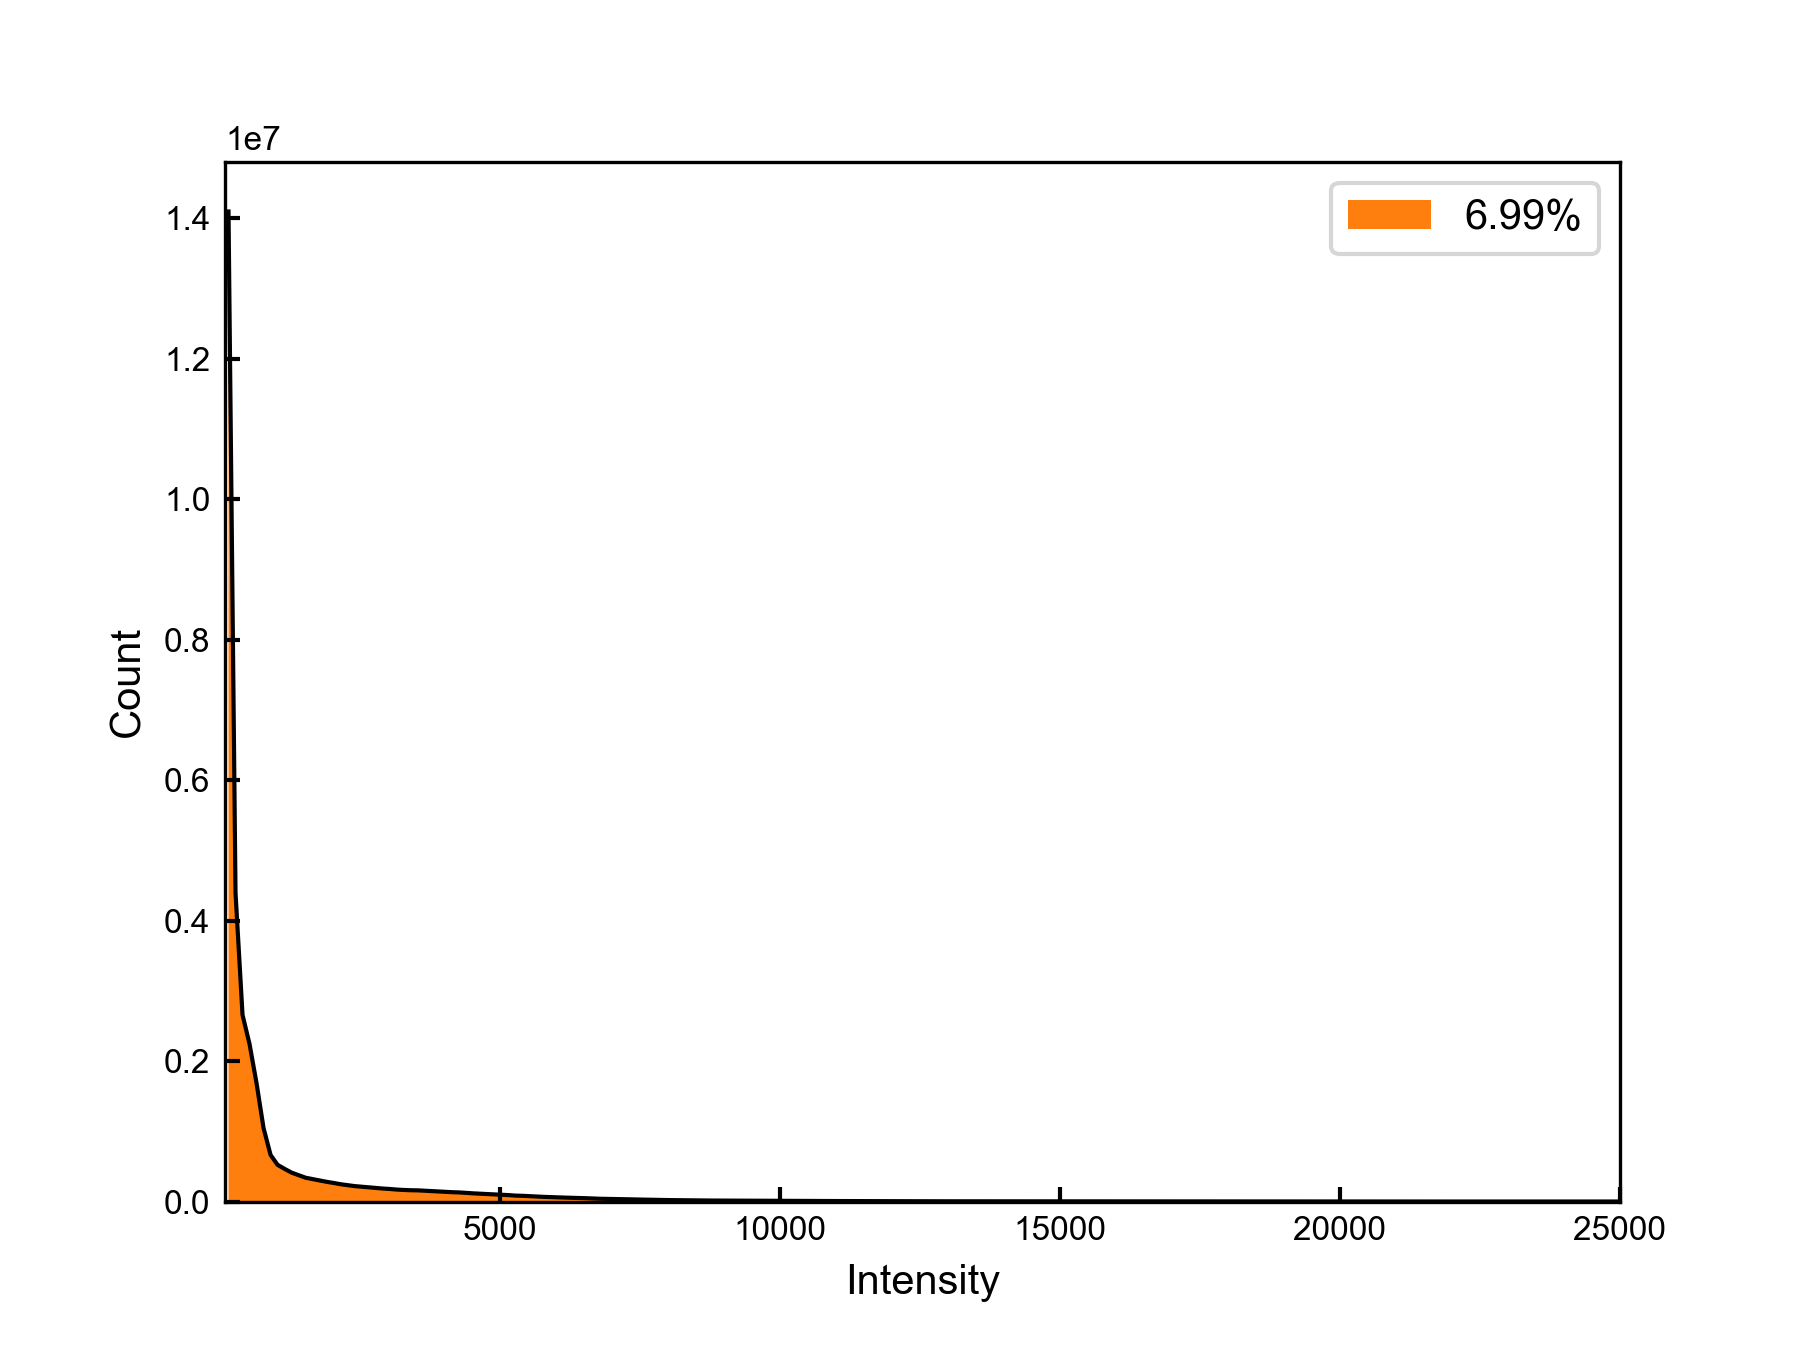


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]

In [19]:
def hist_intsty():

    # 強度範囲 (optional)
    # ilim = (500, 1000)
    ilim = (100, 25000)

    # ヒストグラムのステップ (optional)
    step = 200

    # 閾値
    intsty_threshold = (100, 40000)

    if True:

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.array(f["data"][()]) # type: ignore

        # 例外処理
        if not ("ilim" in locals()):
            ilim = (
                float(intsty.min()),
                float(intsty.max())
            )
        if not ("step" in locals()):
            step = int(ilim[1] - ilim[0])

        # ヒストグラムを計算する
        bins = np.linspace(*ilim, step) # type: ignore
        centers = (bins[1:] + bins[:-1])/2 # type: ignore
        hist, _ = np.histogram(
            intsty,
            bins = bins
        )

        # マスク作成
        mask_threshold = (centers > intsty_threshold[0]) * (centers < intsty_threshold[1])

        # 集計
        occupation_valid = np.sum((intsty > intsty_threshold[0]) * (intsty < intsty_threshold[1])) / intsty.reshape(-1).shape[0]
        
        # figの定義
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # plot
        ax.plot(
            centers,
            hist,
            lw = 1,
            c = "0",
            zorder = 1,
        )

        # fill_between
        ax.fill_between(
            x = centers[mask_threshold],
            y1 = np.zeros(shape = (np.sum(mask_threshold),)),
            y2 = hist[mask_threshold],
            zorder = 0,
            fc = "tab:orange",
            label = "{:.2f}%".format(occupation_valid * 100)
        )

        # axの設定
        ax.set_xlabel("Intensity", fontsize = 10)
        ax.set_ylabel("Count", fontsize = 10)
        ax.set_xlim(ilim)
        ax.set_ylim(0, ax.get_ylim()[1])
        ax.legend(fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 変数の格納
        data[key] = dict()
        data[key]["threshold"] = intsty_threshold
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
hist_intsty()
del hist_intsty

DEBUG      2025-07-13 11:49:14,816 [1397563385.py:52] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\sum_wavelength.png
INFO       2025-07-13 11:49:14,818 [1397563385.py:61] [Add variables]: sum_wavelength (data = 477.95 MB)


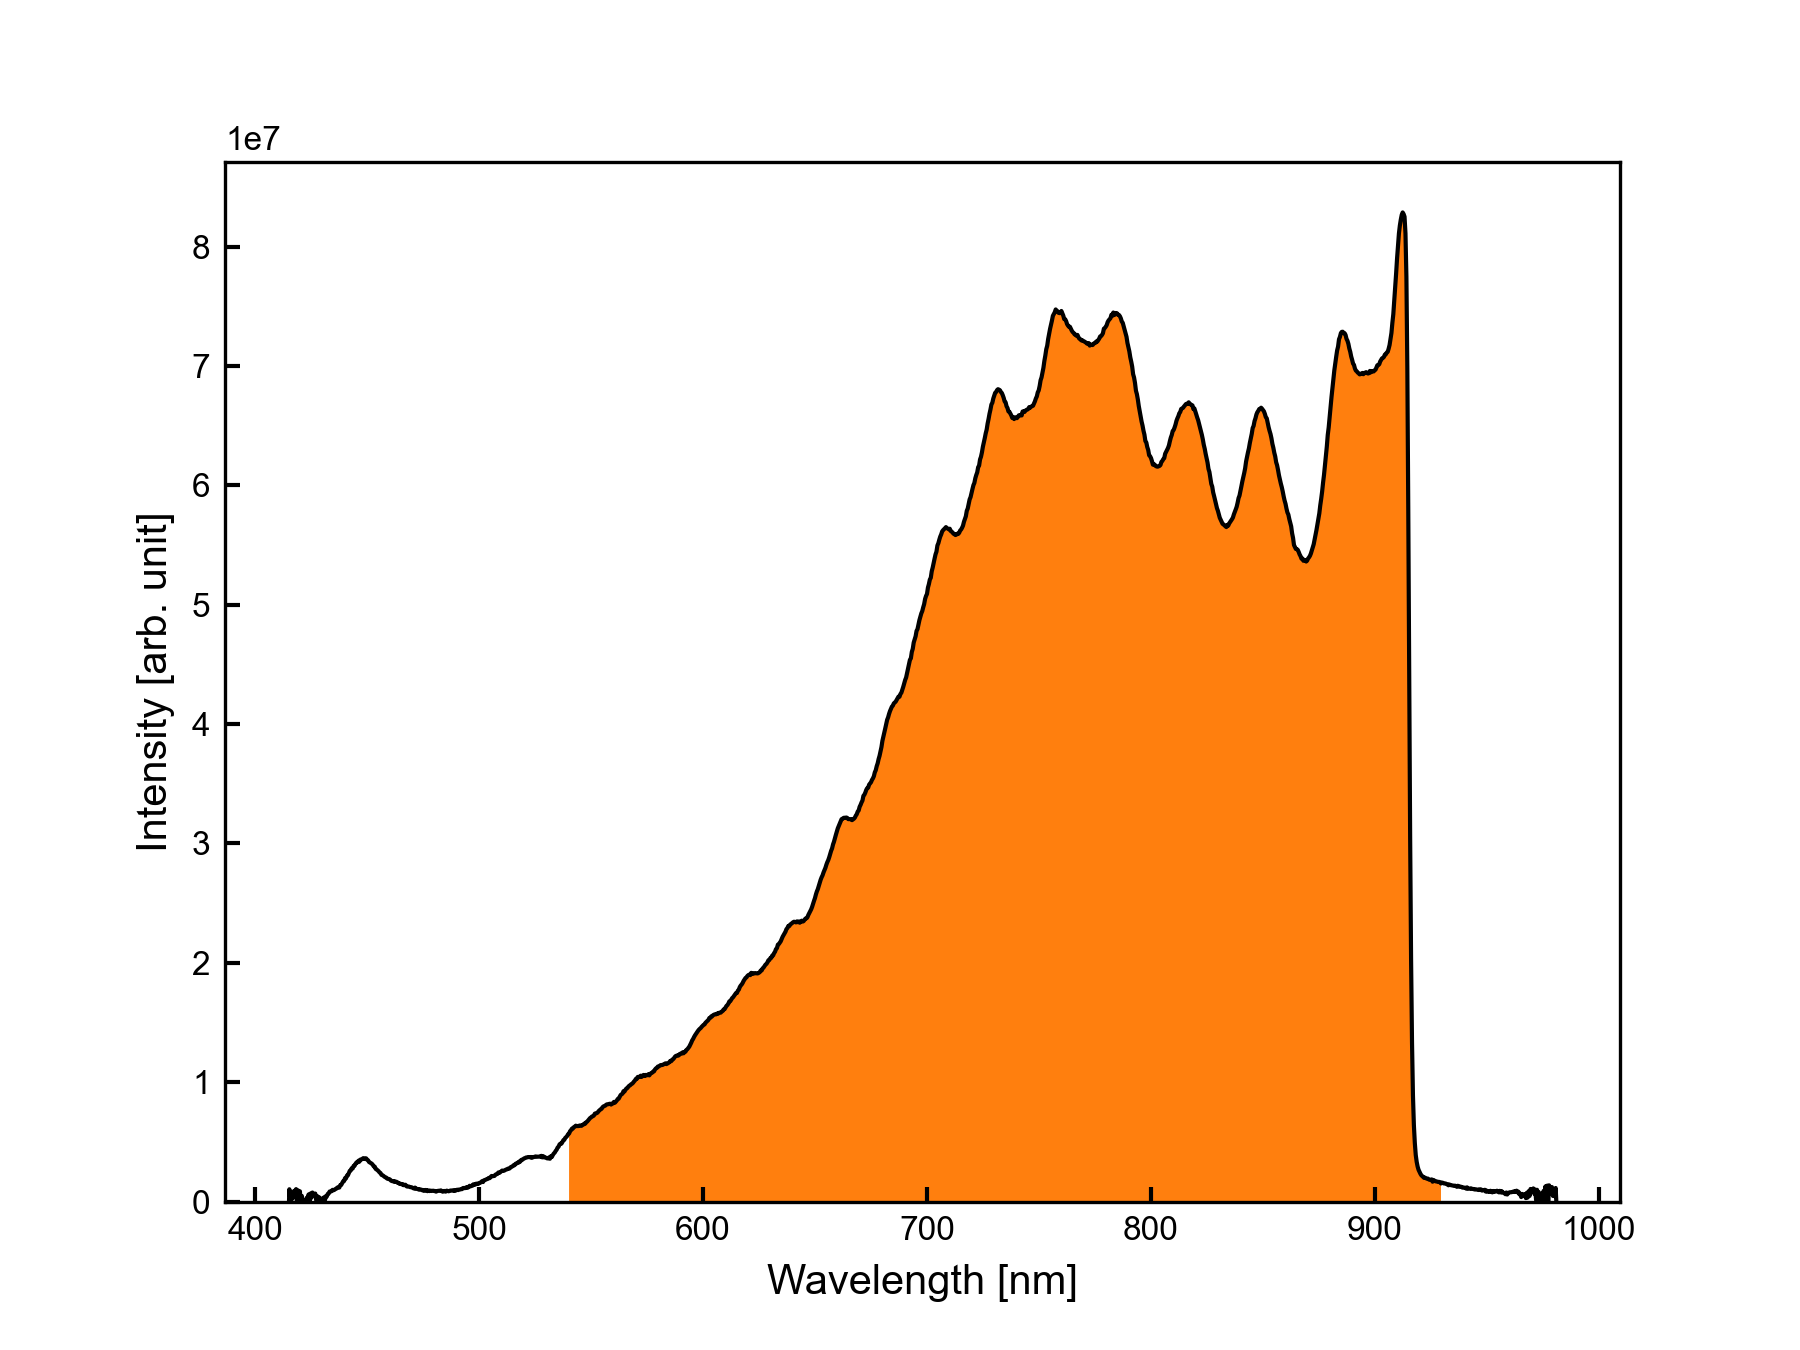


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]

In [ ]:
def sum_wavelength():

    # wavelength領域
    wavelength_range = (600, 800) # nm
    # wavelength_range = (600, 700) # nm
    # wavelength_range = (540, 930) # nm

    if True:

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.sum(np.array(f["data"][()]), axis = (0,1)) # type: ignore
            wavelength = np.array(f["wavelength"][()]) # type: ignore

        # 波長インデックス
        arg0 = np.argmin(np.abs(wavelength - wavelength_range[0]))
        arg1 = np.argmin(np.abs(wavelength - wavelength_range[1]))

        # figの定義
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # plot
        ax.plot(
            wavelength,
            intsty,
            lw = 1,
            c = "0"
        )
        ax.set_ylim((0, ax.get_ylim()[1]))
        ax.fill_between(
            wavelength[arg0:arg1],
            intsty[arg0:arg1],
            fc = "tab:orange"
        )
        
        ax.set_xlabel("Wavelength [nm]", fontsize = 10)
        ax.set_ylabel("Intensity [arb. unit]", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 変数の格納
        data[key] = dict()
        data[key]["range"] = (arg0, arg1)
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)


    return
sum_wavelength()
del sum_wavelength

マスクを作成します。

In [20]:
def make_mask_intsty():

    # データ読み込み
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore

    # maskの作成
    intnsty_mask = np.zeros(intsty.shape).astype(np.bool_)
    intnsty_mask[:,:,data["sum_wavelength"]["range"][0]:data["sum_wavelength"]["range"][1]] = True
    intnsty_mask[intsty <= data["hist_intsty"]["threshold"][0]] = False
    intnsty_mask[intsty >= data["hist_intsty"]["threshold"][1]] = False

    # 変数の格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["mask"] = intnsty_mask
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
make_mask_intsty()
del make_mask_intsty

INFO       2025-07-13 11:53:06,497 [4262524686.py:17] [Add variables]: make_mask_intsty (data = 477.95 MB)



├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
└── make_mask_intsty
    └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]

作成したマスクをアニメーションにします。

In [21]:
def mask_animation():

    # フレーム数
    n_frame = data["make_mask_intsty"]["mask"].shape[0]

    # 横軸
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        wavelength = np.array(f["wavelength"][()]) # type: ignore
    xlim = (wavelength[0], wavelength[-1])

    # 縦軸
    ylim = (0, data["make_mask_intsty"]["mask"].shape[1])

    # 軸
    extent: tuple = (*xlim, *ylim[::-1])

    # fig作成
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4.5)

    # ax の設定
    ax.set_xlabel("Wavelength [nm]", fontsize = 10)
    ax.set_ylabel("Pixel", fontsize = 10)

    # animation
    ims = []
    for i in range(n_frame):
        # imshow
        imshow = ax.imshow(
            data["make_mask_intsty"]["mask"][i],
            aspect = "auto",
            cmap = "viridis",
            extent = extent,
        )

        # text
        tex = ax.text(
            x = 0,
            y = 1.01,
            s = "frame number = {:>4}".format(i),
            fontsize = 12,
            transform = ax.transAxes
        )

        # フレームに追加
        ims.append([imshow, tex])
        simple_progress_bar(i+1, n_frame)

    #. Save
    logger.debug("[Save]: Animation")
    ani = anim.ArtistAnimation(fig, ims, interval = 300)
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))

    plt.close()
    return
mask_animation()
del mask_animation

Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■-------------]  70% (653/935) 

DEBUG      2025-07-13 11:53:08,581 [646891443.py:50] [Save]: Animation


Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (935/935) 


INFO       2025-07-13 11:55:34,278 [646891443.py:55] [Save]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\mask_animation.mp4


## 3. 校正

校正データを作成します。

In [22]:
def calibration():

    # データ読み込み
    with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore
        wavelength = np.array(f["wavelength"][()]) # type: ignore

    # スペクトルデータの補完
    spectrum_interp = sp.interpolate.interp1d(
        *data["add_calib"]["spectrum"]["csvdata"],
        kind = "cubic"
    )
    data["add_calib"]["spectrum"]["interp"] = spectrum_interp(wavelength)
    logger.debug("[Calc]: Interpolation of spectrum data")

    # 補正
    calibrated = dict()
    calibrated["wavelength"] = wavelength
    calibrated["data"] = (
        intsty
        * np.stack(
            [np.vstack(
                [data["add_calib"]["spectrum"]["interp"]]*intsty.shape[1]
            )]*intsty.shape[0],
            axis = 0
        )
        / np.stack(
            [np.vstack(
                [data["add_calib"]["OD"]["up"]]*(intsty.shape[1]//2)
                + [data["add_calib"]["OD"]["down"]]*(intsty.shape[1]//2)
            )]*intsty.shape[0],
            axis = 0
        )
    )
    logger.debug("[Calc]: Correction")

    # データ格納
    key = sys._getframe().f_code.co_name
    hdffile = os.path.join(cachedir, key+".hdf")
    with h5py.File(hdffile, mode = "w") as f:
        f.create_dataset(
            name = "data",
            data = calibrated["data"],
            dtype = np.float64,
        )
        f.create_dataset(
            name = "wavelength",
            data = calibrated["wavelength"],
            dtype = np.float64,
        )
        h5_tree(f)
    data[key] = dict()
    data[key]["hdffile"] = hdffile
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
calibration()
del calibration

DEBUG      2025-07-13 11:56:18,595 [4063728594.py:14] [Calc]: Interpolation of spectrum data
DEBUG      2025-07-13 11:56:24,114 [4063728594.py:35] [Calc]: Correction
INFO       2025-07-13 11:56:34,178 [4063728594.py:54] [Add variables]: calibration (data = 477.95 MB)


<HDF5 file "calibration.hdf" (mode r+)>
├── data ((935, 400, 1340), float64)
└── wavelength ((1340,), float64)

├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]
└── calibration
    └── hdffile <class 'str'>

## 4. 計算範囲の設定

ピクセル範囲を設定します。

DEBUG      2025-07-13 11:57:51,885 [1263635125.py:84] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\set_range_pix.png
INFO       2025-07-13 11:57:51,886 [1263635125.py:93] [Add variablse]: set_range_pix (data = 477.95 MB)


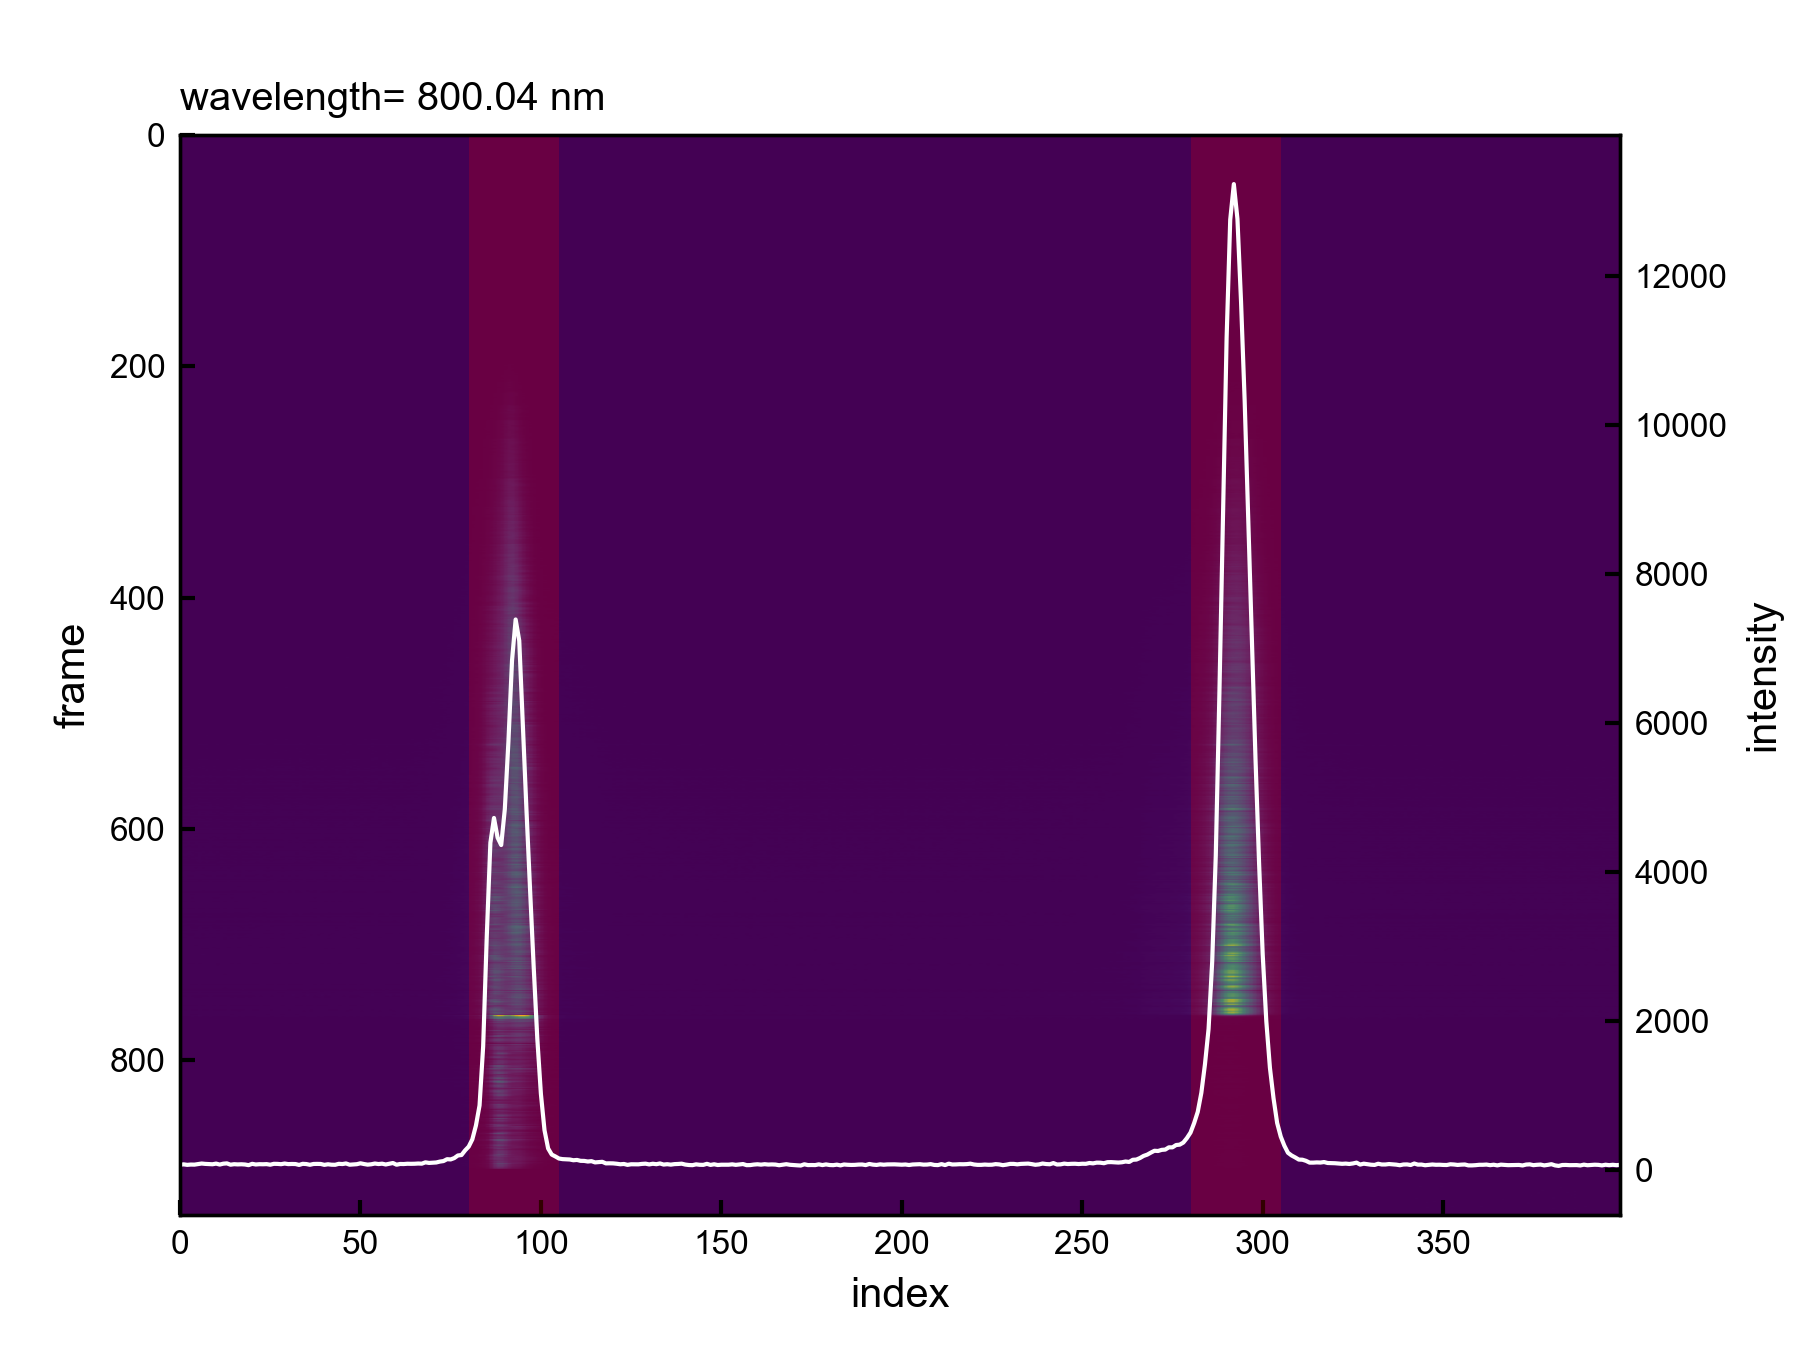


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
└── set_range_pix
    └── pix_range <class 'tuple'>

In [26]:
def set_range_pix():

    # pix ranges
    xrange = ((80,105), (280, 305))

    # 参照する波長
    ref_wavelength = 800 # nm

    # 参照するフレーム
    ref_frame = 700

    if True: # Main
        """更新履歴
        * 2025/06/25: プロットの色を変更しました。
        """

        # データ読み込み
        with h5py.File(data["read_spe"]["hdffile"], mode = "r") as f:
            intsty = np.array(f["data"][()]) # type: ignore
            wavelength = np.array(f["wavelength"][()]) # type: ignore

        # 参照する波長データ
        arg_wavelength = np.argmin(np.abs(wavelength - ref_wavelength))

        # 強度時空間データ
        imshow = intsty.transpose(2,0,1)[arg_wavelength]

        # 強度空間データ
        plot = imshow[ref_frame]

        # figure作成
        fig = plt.figure()
        fig.set_size_inches(6,4.5)
        fig.set_dpi(300)

        # ax作成
        axs = []
        axs.append(fig.add_axes(rect = (0.1,0.1,0.8,0.8)))
        axs.append(axs[0].twinx())
        axs[0].set_xlabel("index", fontsize = 10)
        axs[0].set_ylabel("frame", fontsize = 10)
        axs[1].set_ylabel("intensity", fontsize = 10)
        axs[0].set_title(
            "wavelength= {:.2f} nm".format(wavelength[arg_wavelength]),
            loc = "left")

        # imshow
        axs[0].imshow(
            imshow,
            extent = (0, imshow.shape[1]-1,imshow.shape[0]-1, 0),
            aspect = "auto"
        )

        # plot
        axs[1].plot(
            np.arange(plot.shape[0]),
            plot,
            c = "1",
            lw = 1
        )
        axs[1].set_ylim(axs[1].get_ylim())

        # pixrangeを描写
        for i in range(2):
            axs[1].fill_betweenx(
                axs[1].get_ylim(),
                xrange[i][0],
                xrange[i][-1],
                fc = "red",
                alpha = 0.2,
            )

        # グラフ保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # # データ格納
        data[key] = dict()
        data[key]["pix_range"] = xrange
        logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
set_range_pix()
del set_range_pix

フレーム範囲を指定します。

DEBUG      2025-07-13 11:58:03,554 [3112726144.py:67] [Save fig]: c:\Users\okaza\pythonenv\lf\twocolor\.cache\set_range_frame.png
INFO       2025-07-13 11:58:03,554 [3112726144.py:77] [Add variables]: set_range_frame (data = 477.95 MB)


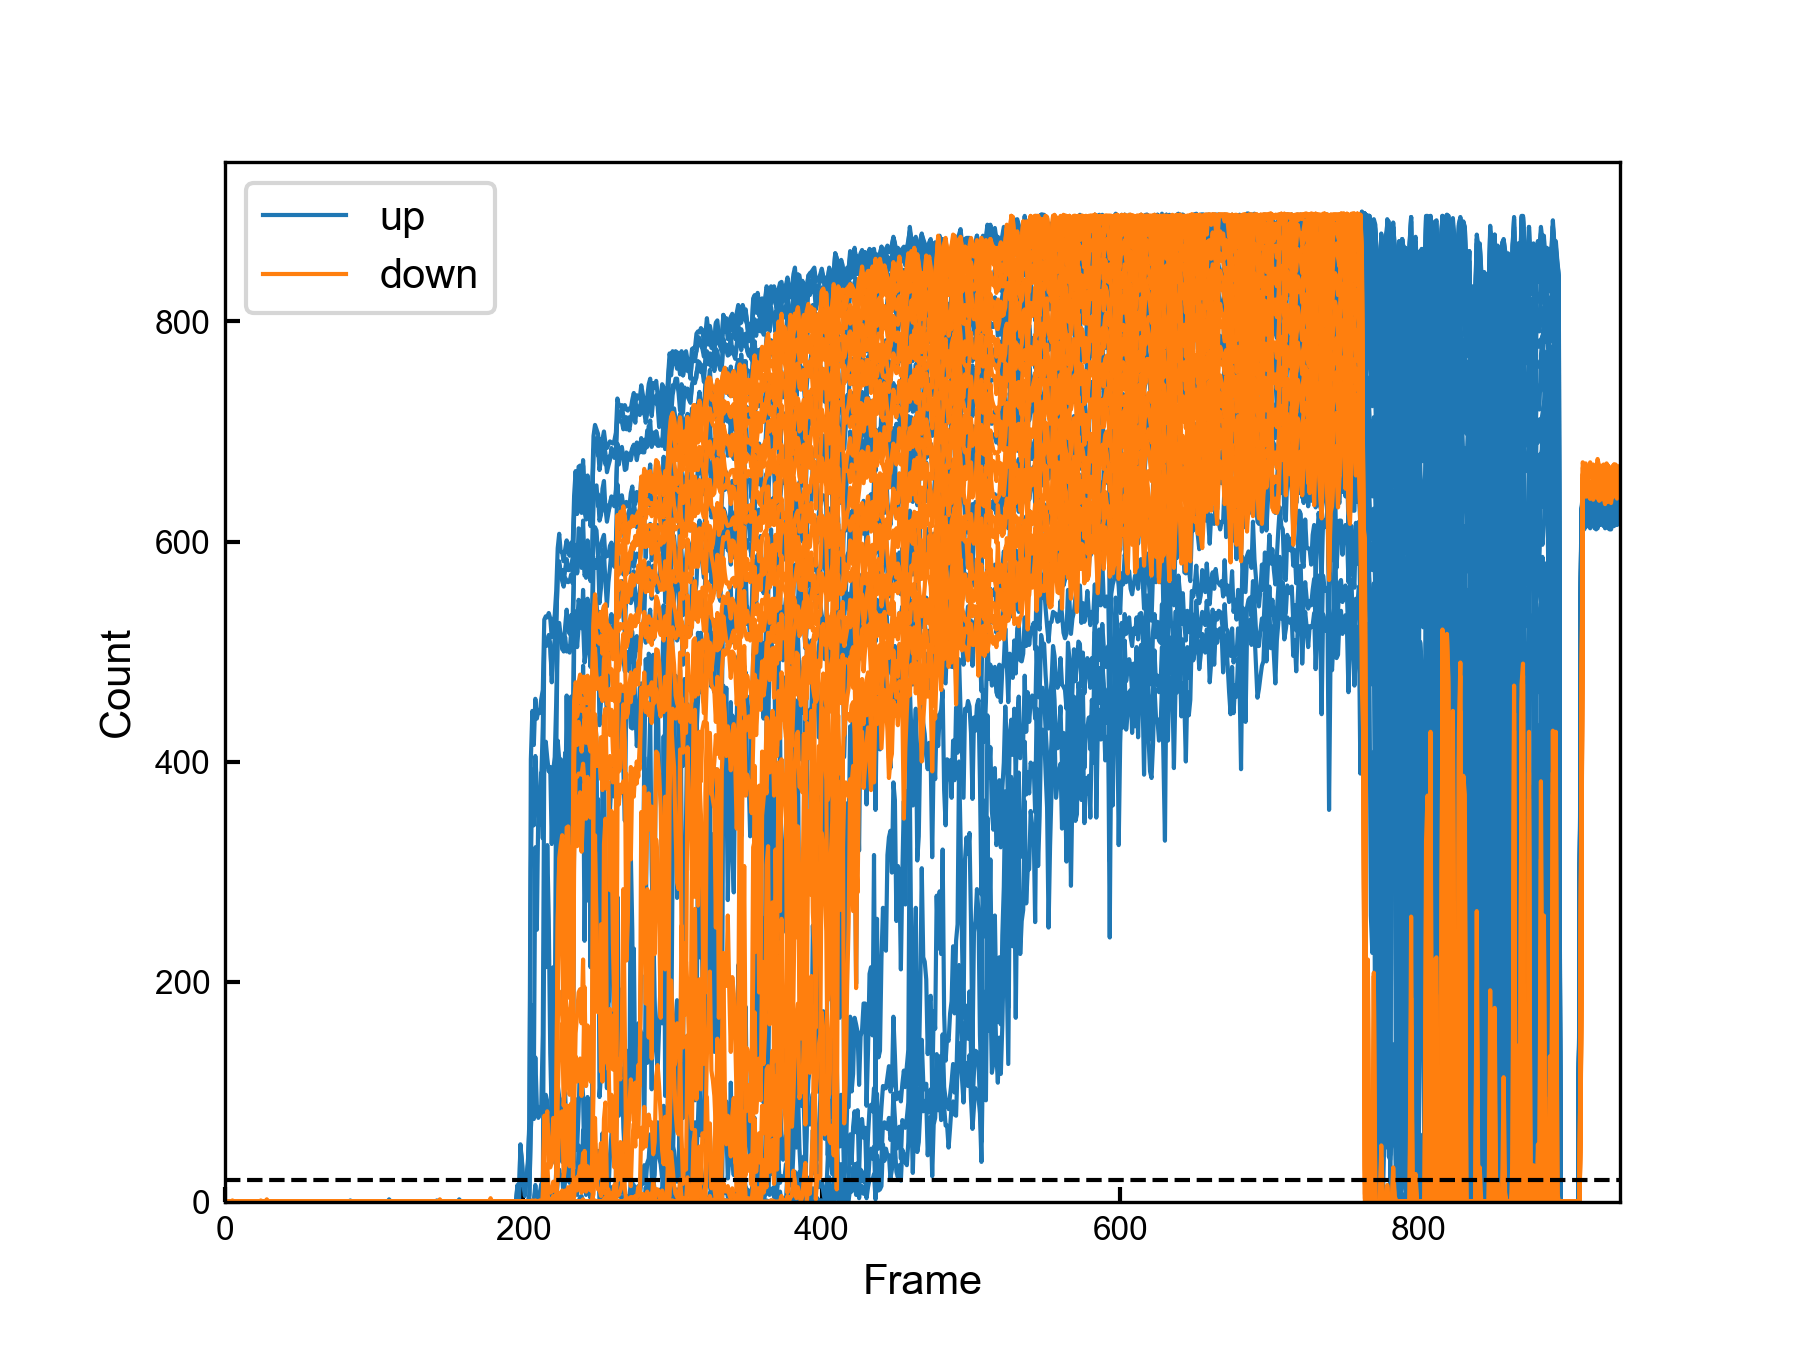


├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
└── set_range_frame
    └── threshold <class 'int'>

In [27]:
def set_range_frame():

    # 閾値
    count_threshold = 20

    if True:

        # データの読み込み
        up_masked = np.sum(data["make_mask_intsty"]["mask"].transpose(1,2,0)[data["set_range_pix"]["pix_range"][0][0]:data["set_range_pix"]["pix_range"][0][1]], axis = 1)
        down_masked = np.sum(data["make_mask_intsty"]["mask"].transpose(1,2,0)[data["set_range_pix"]["pix_range"][1][0]:data["set_range_pix"]["pix_range"][1][1]], axis = 1)

        # フレーム数
        n_frame = up_masked.shape[1]

        # figの作成
        fig, ax = plt.subplots()
        fig.set_size_inches((6,4.5))
        fig.set_dpi(300)

        # up
        for i in range(up_masked.shape[0]):
            ax.plot(
                np.arange(n_frame),
                up_masked[i],
                lw = 1,
                c = "tab:blue",
                label = None if i else "up"
            )

        # down
        for i in range(down_masked.shape[0]):
            ax.plot(
                np.arange(n_frame),
                down_masked[i],
                lw = 1,
                c = "tab:orange",
                label = None if i else "down"
            )

        # threshold
        ax.plot(
            [0, n_frame],
            [count_threshold]*2,
            c = "0",
            lw = 1,
            ls = "dashed"
        )

        # axの設定
        ax.legend(fontsize = 10)
        ax.set_xlim((0,n_frame))
        ax.set_ylim((0, ax.get_ylim()[-1]))
        ax.set_xlabel("Frame", fontsize = 10)
        ax.set_ylabel("Count", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["threshold"] = count_threshold
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 出力
        display(Image(filename = imgfilename, width = 600))
        dict_tree(data)

    return
set_range_frame()
del set_range_frame

## 5. 計算データの作成

計算用のデータを作成します。

In [28]:
def get_valid():

    # データ読み込み
    with h5py.File(data["calibration"]["hdffile"], mode = "r") as f:
        intsty = np.array(f["data"][()]) # type: ignore
        wavelength = np.array(f["wavelength"][()]) # type: ignore

    # フレーム数
    n_frame = intsty.shape[0]
    
    # 格納変数の定義
    valid_data = dict()

    # up and down
    for i, stream in enumerate(["up", "down"]):
        valid_data[stream] = dict()
        for pix in range(*data["set_range_pix"]["pix_range"][i]):

            # each pix
            valid_data[stream]["pix = {}".format(pix)] = dict()
            for j in range(n_frame):

                # データの選択
                intdata = intsty[j][pix]
                maskdata = data["make_mask_intsty"]["mask"][j][pix]

                if (np.sum(maskdata) > data["set_range_frame"]["threshold"]):
                    data_masked = intdata[maskdata]
                    wavelength_masked = wavelength[maskdata]
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)] = dict()
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)]["data"] = data_masked
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)]["wavelength"] = wavelength_masked
                else:
                    valid_data[stream]["pix = {}".format(pix)]["frame = {}".format(j)] = None
    logger.info("[Calc]: valid_data (size = {:.2f} MB)".format(get_total_size(valid_data)/1024/1024))

    # データ格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["data"] = [valid_data]
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

    # 出力
    dict_tree(data)    

    return
get_valid()
del get_valid

INFO       2025-07-13 11:58:21,399 [41636476.py:35] [Calc]: valid_data (size = 313.49 MB)
INFO       2025-07-13 11:58:21,456 [41636476.py:41] [Add variables]: get_valid (data = 791.44 MB)



├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
├── set_range_frame
│   └── threshold <class 'int'>
└── get_valid
    └── data <class 'list'>

## 6. 温度計算

In [29]:
import threading
import concurrent.futures as confu

温度計算をします

In [30]:
def calc_temp():

    # keyリストの作成
    key_list = []
    for stream in data["get_valid"]["data"][0].keys():
        for pix in data["get_valid"]["data"][0][stream].keys():
            for frame in data["get_valid"]["data"][0][stream][pix].keys():
                key_list.append(dict({
                    "stream": stream,
                    "pix": pix,
                    "frame": frame
                }))

    # 出力格納用変数の定義
    key = sys._getframe().f_code.co_name
    hdffilename = os.path.join(cachedir, key+".hdf")

    # ファイルテンプレート作成（最初に1回だけ）
    with h5py.File(hdffilename, mode="w") as f:
        for stream in data["get_valid"]["data"][0].keys():
            g = f.create_group(name = stream)
            for pix in data["get_valid"]["data"][0][stream].keys():
                gg = g.create_group(pix)
                for frame in data["get_valid"]["data"][0][stream][pix].keys():
                    ggg  = gg.create_group(frame)
                    if data["get_valid"]["data"][0][stream][pix][frame] is not None:
                        length = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"].shape[0]
                        ggg.create_dataset(
                            name = "wavelength",
                            data = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"],
                            dtype = np.float64,
                            shape = (length,)
                        )
                        ggg.create_dataset(
                            name = "data",
                            dtype = np.float64,
                            shape = (length*(length-1)/2,)
                        )
    logger.debug("Template file created: " + os.path.abspath(hdffilename))
    print_fileinfo(hdffilename)

    # lock
    lock = threading.Lock()

    # 関数の定義
    def process(i_process):

        # key
        stream = key_list[i_process]["stream"]
        pix = key_list[i_process]["pix"]
        frame = key_list[i_process]["frame"]

        # 例外処理
        if data["get_valid"]["data"][0][stream][pix][frame] is None:
            return i_process, None

        # data attraction
        i = data["get_valid"]["data"][0][stream][pix][frame]["data"]
        w = data["get_valid"]["data"][0][stream][pix][frame]["wavelength"]
        mask = ~np.tril(np.ones([w.shape[0]]*2)).astype(np.bool_)

        # 波長の計算
        wset = np.stack(np.meshgrid(*([w]*2)), axis = -1)[mask].T
        lnW = np.log(wset[0]/wset[1])
        invW = (np.reciprocal(wset[0]) - np.reciprocal(wset[1]))

        # 強度の計算
        iset = np.stack(np.meshgrid(*([i]*2)), axis = -1)[mask].T
        lnR = np.log(iset[0]/iset[1])

        # 温度を算出
        constant = 1e9 # nm -> m
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann*constant * invW / (lnR + 5 * lnW)
        
        return i_process, temperature
    logger.debug("Define the function")

    # 演算
    with confu.ThreadPoolExecutor() as tpe:

        # 演算指示
        futures = [tpe.submit(process, i_process) for i_process in range(len(key_list))]

        # 終わったプロセスから順に出力
        for i, future in enumerate(confu.as_completed(futures)):
            
            # データ読み込み
            i_process, temp = future.result()

            # 例外処理
            if temp is None:
                continue

            # key 決定
            stream = key_list[i_process]["stream"]
            pix = key_list[i_process]["pix"]
            frame = key_list[i_process]["frame"]

            # 書き換え
            with lock:
                with h5py.File(hdffilename, mode = "r+") as f:
                    f[stream][pix][frame]["data"][:] = temp # type: ignore
            simple_progress_bar(i+1, len(key_list))

    
    # データ格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["hdffile"] = hdffilename
    logger.info("[Add variablse]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
calc_temp()
del calc_temp

DEBUG      2025-07-13 11:58:32,262 [1266764683.py:39] Template file created: c:\Users\okaza\pythonenv\lf\twocolor\.cache\calc_temp.hdf
DEBUG      2025-07-13 11:58:32,264 [1266764683.py:76] Define the function



File name: c:\Users\okaza\pythonenv\lf\twocolor\.cache\calc_temp.hdf
File size: 219,830,624 bites
Last update time: 2025-07-13 11:58:32.256519

Progress: [■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■] 100% (46750/46750) 


INFO       2025-07-13 12:23:35,954 [1266764683.py:110] [Add variablse]: calc_temp (data = 791.44 MB)



├── read_spe
│   └── hdffile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── hist_intsty
│   └── threshold <class 'tuple'>
├── sum_wavelength
│   └── range <class 'tuple'>
├── make_mask_intsty
│   └── mask <class 'numpy.ndarray'> [shape = (935, 400, 1340)]
├── calibration
│   └── hdffile <class 'str'>
├── set_range_pix
│   └── pix_range <class 'tuple'>
├── set_range_frame
│   └── threshold <class 'int'>
├── get_valid
│   └── data <class 'list'>
└── calc_temp
    └── hdffile <class 'str'>